In [1]:
import numpy as np
from scipy.fft import fft2,ifft2,fftfreq,fftshift,ifftshift
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
from scipy.special import spherical_jn, spherical_yn , hankel1,lpmv
import cmath

In [2]:
def Optica(U0,X,Y,z,lamb):
    A = (fft2((U0)))
    Lx = np.max(abs(X))
    Ly= np.max(abs(Y))

    deltax = 2*Lx/len(U0)
    deltay = 2*Ly/len(U0)    

    fx = ( fftfreq(len(U0),deltax) )  
    fy = ( fftfreq(len(U0),deltay) )   
    
    
    Fx,Fy = np.meshgrid(fx,fy)
    K = 2*np.pi/lamb

    # Handle cases where u is negative
    u = K**2-(2*np.pi*Fx)**2-(2*np.pi*Fy)**2
    sqrt_u = 1j*z*np.sqrt(abs(u))
    sqrt_u[np.where(u<0)] = 1j*sqrt_u[np.where(u<0)]

    return  ( ifft2( ( A*np.exp(sqrt_u) ) ) )

In [3]:
def mask_esp(X,Y,R,n):
  n=n+2
  U0,L =[],np.arange(1,n-1,1)*2*R/(n-1)
  for i in L:
    U0.append( (X**2+Y**2>R**2 - (i - R)**2).astype(float))

  return U0,np.ones(n-3)*L[0]

def FiguraOptica2(U0,X,Y,lamb,z):
  ZX,ZY,ZD=[],[],[]

  uu = U0.copy()
  uu[U0== 0 ]= 3
  ZX.append( uu[len(uu)//2] )
  ZY.append( uu[Y==0] )

  gg = 0
  for i in range(len(z)):
    U = Optica(U0,X,Y,z[i]+gg,lamb)
    ZX.append(abs(U[len(U0)//2])**2)
    ZY.append(abs(U[Y==0])**2)

    
  return ZX,ZY,ZD

def FiguraOpticaH(U0,X,Y,lamb,L,z,z0):
  A= U0[0]
  ZX,ZY,ZD=[],[],[]
 
  for i in range(len(L)):
    A =  Optica(A*U0[i],X,Y,L[i],lamb)
    if i> (len(L)//2-1):
      for j in range(0, len(z0)):
        a = Optica(A,X,Y,z0[j],lamb )
        if j ==0:
          uu = a
          uu[U0[i]== 0 ]= 3
          uu[U0[i]!= 0] = abs(uu[U0[i]!=0])**2
          ZX.append( (uu[len(a)//2]).astype('float32') )
        else:
          ZX.append( abs(a[len(a)//2])**2 )
      
  for i in range(len(z)):
    U = Optica(A*U0[-1],X,Y,z[i],lamb)
    if i ==0:
      uu = U.copy()
      uu[U0[-1]== 0]= 3
      uu[U0[-1]!= 0] = abs(uu[U0[-1]!=0])**2
      ZX.append( (uu[len(U)//2]).astype('float32') )
    else:
      ZX.append( abs(U[len(U)//2])**2 )

  return ZX,ZY,ZD

In [4]:
import numpy as np
from scipy.special import spherical_jn, spherical_yn , sph_harm, hankel1,lpmv
import matplotlib.pyplot as plt

In [5]:
def MieCoefCond2(x, n, k1):
    jn = spherical_jn(n, x)
    jn1 = spherical_jn(n+1,x)
    jn_1 = spherical_jn(n-1,x)
    
    hankeln = np.sqrt(np.pi/(2*x))*hankel1(n+1/2,x)
    hankeln1 = np.sqrt(np.pi/(2*x))*hankel1(n+1+1/2,x)
    hankeln_1 = np.sqrt(np.pi/(2*x))*hankel1(n-1+1/2,x)

    a = -(jn + x *1/2* (  x* (jn_1-jn1) + jn ))/(hankeln + x  *1/2* ( x*(hankeln_1-hankeln1) + hankeln))

    b = - jn/hankeln
    

    return a, b


print(MieCoefCond2(10,2,0.005))

((-0.4177336154006738+0.49318580876273777j), (-0.5892895089370762-0.49196278679771666j))


In [6]:
def E_SCATnm(n, a_n, b_n, k, x, y, z):
    r = np.sqrt(x**2+y**2+z**2)
    phi = 0
    theta = np.arccos(z/r)
    #AJUSTE
    zer0 = (np.isnan(theta)[0])
    theta[zer0] = 0
    
    kr = k*r

    hn = np.sqrt(np.pi/(2*kr))*hankel1(n+1/2,kr)
    hn1 = np.sqrt(np.pi/(2*kr))*hankel1(n+1/2+1,kr)
    #AJUSTE
    hn[r==0] = x[r==0]*0
    hn1[r==0] = x[r==0]*0

    Pn1 = lpmv(1,n+1,np.cos(theta))
    Pn = lpmv(1,n,np.cos(theta))

    Gn = 1j**(n) 
    prefac = -Gn/(n*(n+1)) * (2*n+1)*1j

    dP = (n * Pn1 - (n + 1) * np.cos(theta) * Pn) / np.sin(theta)
    P = Pn / np.sin(theta)
    
    zero_theta_indices = (np.isclose(theta, 0))
    dP[zero_theta_indices] = -0.5 * n * (n + 1)
    P[zero_theta_indices] = -0.5 * n * (n + 1)
    
    

    term_r = -a_n/kr * hn  *Pn*n*(n+1)*np.cos(phi)

    term_the = (-a_n/kr* ( (n+1)*hn - kr*hn1 )* dP -1j* b_n * hn *P)*np.cos(phi)
    
    term_phi = (a_n/kr* ( (n+1)*hn - kr*hn1 )* P +1j* b_n * hn *dP)* np.sin(phi)

    
    
        
    return prefac* ( np.array([term_r*np.cos(phi)*np.sin(theta),term_r*np.sin(theta)*np.sin(phi),term_r*np.cos(theta)]) + 
     np.array([term_the*np.cos(phi)*np.cos(theta) ,term_the*np.cos(theta)*np.sin(phi), - term_the*np.sin(theta)]) + 
     np.array([-term_phi *np.sin(phi) , term_phi*np.cos(phi) , term_phi *0 ]) )
    

In [8]:
# Constants
N0 = 1240
wavelength = 0.632
radius10 = 100
k = 2 * np.pi / wavelength
x_value = k * radius10

y = 0
x = np.linspace(-1.3*radius10,1.3*radius10,500)

z = np.linspace(0,6*radius10,500)
x,z=np.meshgrid(x,z)

E001_sca = 0  # Initialize the electric field array
for i in range(1,N0):
    
    a_nm1,b_nm1 = MieCoefCond2(x_value, i, k)
    if np.isnan(abs(a_nm1)):
        break

    # Calculate the scattered electric field for both m=1 and m=-1
    E001_sca += E_SCATnm(i, a_nm1, b_nm1, k, x, y, z) 
print(E001_sca)

[[[-0.17798726+2.50546637e-01j  0.03999409-3.07662681e-01j
    0.10441052+2.95295873e-01j ...  0.10441052+2.95295873e-01j
    0.03999409-3.07662681e-01j -0.17798726+2.50546637e-01j]
  [-0.07706451-2.99088742e-01j  0.20020009+2.38961863e-01j
   -0.28361943-1.36285561e-01j ... -0.28361943-1.36285561e-01j
    0.20020009+2.38961863e-01j -0.07706451-2.99088742e-01j]
  [ 0.26535667+1.60669504e-01j -0.30988484-4.44268245e-02j
    0.30691435-7.49590298e-02j ...  0.30691435-7.49590298e-02j
   -0.30988484-4.44268245e-02j  0.26535667+1.60669504e-01j]
  ...
  [-0.05883696+1.34806120e-02j -0.04683529+3.93260516e-02j
   -0.02880166+4.15791864e-02j ... -0.02880166+4.15791864e-02j
   -0.04683529+3.93260516e-02j -0.05883696+1.34806120e-02j]
  [-0.03601163+5.10399906e-02j -0.01086956+5.41506133e-02j
   -0.00518203+4.87394773e-02j ... -0.00518203+4.87394773e-02j
   -0.01086956+5.41506133e-02j -0.03601163+5.10399906e-02j]
  [ 0.0067486 +5.95217043e-02j  0.01828251+4.57861971e-02j
    0.0218381 +4.86083806

In [ ]:
E0_inc = np.array([np.exp(1j*k*z),
                   np.ones(500**2).reshape(500,500)*0,
                   0*np.ones(500**2).reshape(500,500) ])
E1 = E0_inc+E001_sca
U0001 = abs(E1[0])**2 + np.abs(E1[1])**2 + np.abs(E1[2])**2


In [10]:
N = 4096
R = 100
x = np.linspace(-9*R,9*R,N,endpoint=False)
X,Y = np.meshgrid(x,x)

A0 = (X**2+Y**2>R**2).astype('float32')

nn = len(x[abs(x)<=1.3*R])
#nn,nn_ = 591,10
zz1 = np.linspace(0,6*R,nn)

lamb = 0.632

ZX01,ZY01,ZD01 = FiguraOptica2((X**2+Y**2>R**2).astype(float),X,Y,lamb,zz1)

A,L = mask_esp(X,Y,R,3)
zz0 = np.arange(0,L[0], abs(zz1[0]-zz1[1]) )
zz = np.arange(0,6*R - L[0] * (len(L)//2 - 0) , abs(zz1[0]-zz1[1])  )
ZX3,ZY3,ZD3 = FiguraOpticaH(A,X,Y,lamb,L,zz,zz0)

A,L = mask_esp(X,Y,R,11)
zz0 = np.arange(0,L[0], abs(zz1[0]-zz1[1]) )
zz = np.arange(0,6*R - L[0] * (len(L)//2 - 0) , abs(zz1[0]-zz1[1])  )
ZX11,ZY11,ZD11 = FiguraOpticaH(A,X,Y,lamb,L,zz,zz0)

A,L = mask_esp(X,Y,R,21)
zz0 = np.arange(0,L[0], abs(zz1[0]-zz1[1]) )
zz = np.arange(0,6*R - L[0] * (len(L)//2 - 0) , abs(zz1[0]-zz1[1])  )
ZX21,ZY21,ZD21 = FiguraOpticaH(A,X,Y,lamb,L,zz,zz0)

A,L = mask_esp(X,Y,R,31)
zz0 = np.arange(0,L[0], abs(zz1[0]-zz1[1]) )
zz = np.arange(0,6*R - L[0] * (len(L)//2 - 0) , abs(zz1[0]-zz1[1])  )
ZX31,ZY31,ZD31 = FiguraOpticaH(A,X,Y,lamb,L,zz,zz0)

C:\Users\user\AppData\Local\Temp\ipykernel_24676\4168923100.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  ZX.append( (uu[len(a)//2]).astype('float32') )
C:\Users\user\AppData\Local\Temp\ipykernel_24676\4168923100.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  ZX.append( (uu[len(U)//2]).astype('float32') )


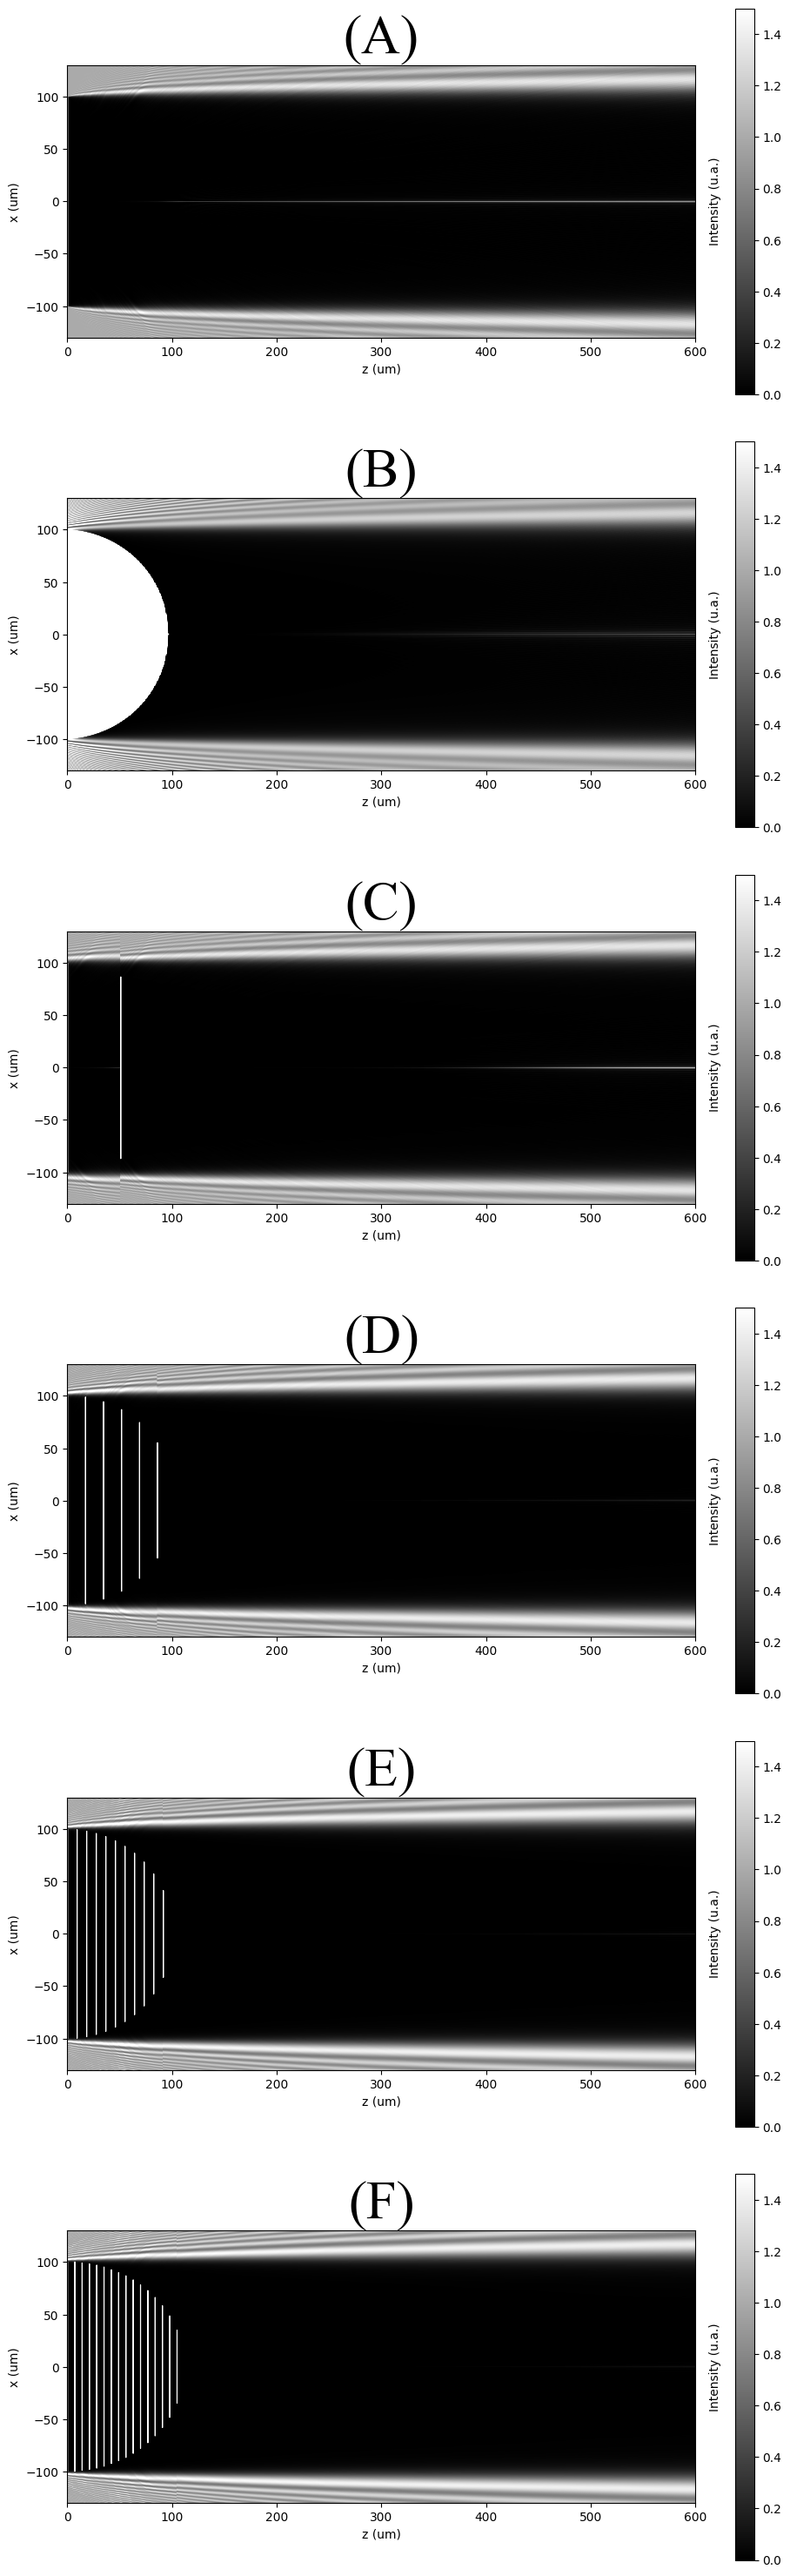

In [14]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(6,1,figsize=(10,30))
vmin,vmax=0,1.5

im=ax[0].imshow(np.transpose(ZX01)[abs(x)<=1.3*R],cmap='gray', extent=[ 0,6*radius10,-1.3*radius10, 1.3*radius10],vmin=vmin,vmax=vmax)
cbar = plt.colorbar(im)
cbar.set_label('Intensity (u.a.)', rotation = 90, labelpad = -60)

ax[0].set_ylabel('x (um)')
ax[0].set_xlabel('z (um)')
ax[0].set_title('(A)',fontname = 'Times New Roman', fontsize = 45)


im=ax[1].imshow(np.transpose(U0001),cmap='gray', extent=[ 0,6*radius10,-1.3*radius10, 1.3*radius10],vmin=vmin,vmax=vmax)
cbar = plt.colorbar(im)
cbar.set_label('Intensity (u.a.)', rotation = 90, labelpad = -60)

ax[1].set_ylabel('x (um)')
ax[1].set_xlabel('z (um)')
ax[1].set_title('(B)',fontname = 'Times New Roman', fontsize = 45)

im=ax[2].imshow(np.transpose(ZX3)[abs(x)<=1.3*R],cmap='gray', extent=[ 0,6*radius10,-1.3*radius10, 1.3*radius10],vmin=vmin,vmax=vmax)
cbar = plt.colorbar(im)
cbar.set_label('Intensity (u.a.)', rotation = 90, labelpad = -60)

ax[2].set_ylabel('x (um)')
ax[2].set_xlabel('z (um)')
ax[2].set_title('(C)',fontname = 'Times New Roman', fontsize = 45)


im=ax[3].imshow(np.transpose(ZX11)[abs(x)<=1.3*R],cmap='gray', extent=[ 0,6*radius10,-1.3*radius10, 1.3*radius10],vmin=vmin,vmax=vmax)
cbar = plt.colorbar(im)
cbar.set_label('Intensity (u.a.)', rotation = 90, labelpad = -60)

ax[3].set_ylabel('x (um)')
ax[3].set_xlabel('z (um)')
ax[3].set_title('(D)',fontname = 'Times New Roman', fontsize = 45)

im=ax[4].imshow(np.transpose(ZX21)[abs(x)<=1.3*R],cmap='gray', extent=[ 0,6*radius10,-1.3*radius10, 1.3*radius10],vmin=vmin,vmax=vmax)
cbar = plt.colorbar(im)
cbar.set_label('Intensity (u.a.)', rotation = 90, labelpad = -60)

ax[4].set_ylabel('x (um)')
ax[4].set_xlabel('z (um)')
ax[4].set_title('(E)',fontname = 'Times New Roman', fontsize = 45)

im=ax[5].imshow(np.transpose(ZX31)[abs(x)<=1.3*R],cmap='gray', extent=[ 0,6*radius10,-1.3*radius10, 1.3*radius10],vmin=vmin,vmax=vmax)
cbar = plt.colorbar(im)
cbar.set_label('Intensity (u.a.)', rotation = 90, labelpad = -60)

ax[5].set_ylabel('x (um)')
ax[5].set_xlabel('z (um)')
ax[5].set_title('(F)',fontname = 'Times New Roman', fontsize = 45)

plt.tight_layout()
plt.savefig('zMieComparasS.svg',dpi=500)